<a href="https://colab.research.google.com/github/chitingchiang/style_transfer/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as pt
import matplotlib.style
matplotlib.style.use('default')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from skimage.io import imread
from skimage.transform import resize
import time

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/style_transfer

content_img = np.array(imread('content.png'), dtype=np.float32)
style_img = np.array(imread('style.png'), dtype=np.float32)

n_pixel = content_img.shape[0]
n_channel=content_img.shape[2]

img_mean_val = np.mean(0.5*(content_img+style_img), axis=(0, 1))
img_mean_val = np.array([103.939, 116.779, 123.68])

content_img = content_img-img_mean_val
style_img = style_img-img_mean_val

content_img = content_img[:, :, ::-1]
style_img = style_img[:, :, ::-1]

content_img = np.expand_dims(content_img, axis=0)
style_img = np.expand_dims(style_img, axis=0)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/style_transfer


In [0]:
content_path = tf.keras.utils.get_file('turtle.jpg',
                                       'https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
style_path = tf.keras.utils.get_file('kandinsky.jpg',
                                     'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

def load_image(img_path):
    img = imread(img_path)
    w, h, c = img.shape
    max_dim = 512
    w_new = np.int32(w/np.max([w, h])*max_dim)
    h_new = np.int32(h/np.max([w, h])*max_dim)
    img = resize(img, (w_new, h_new))
    return img

content_img = np.expand_dims(load_image(content_path), axis=0)
style_img = np.expand_dims(load_image(style_path), axis=0)

(1, 384, 512, 3)


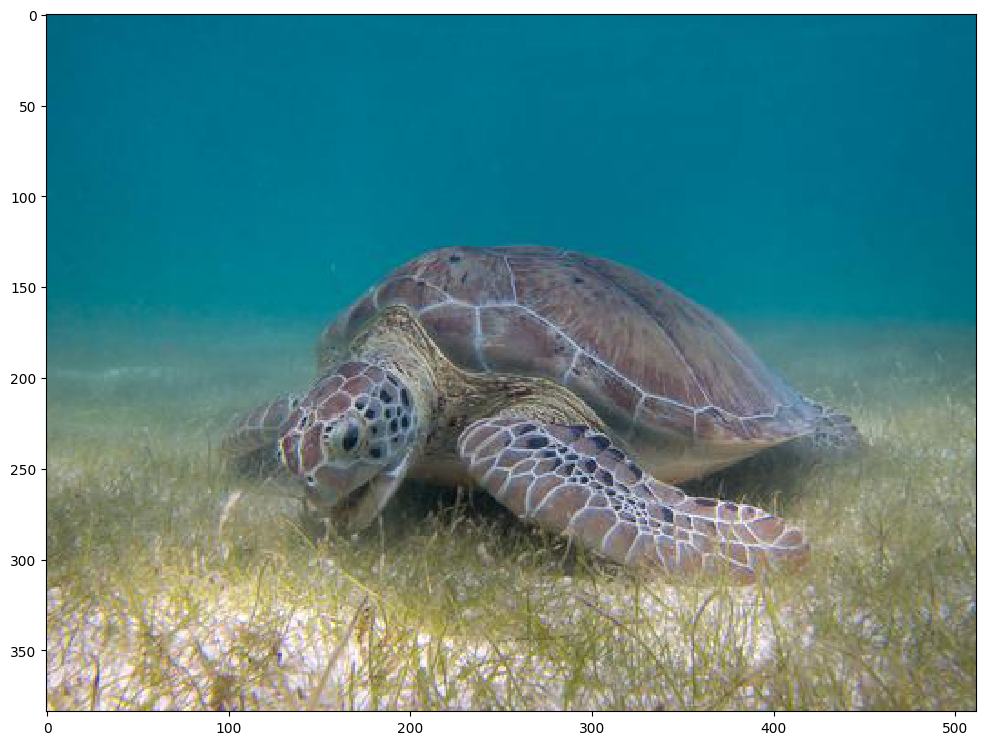

In [3]:
print(content_img.shape)
pt.imshow(content_img[0])

(1, 336, 512, 3)


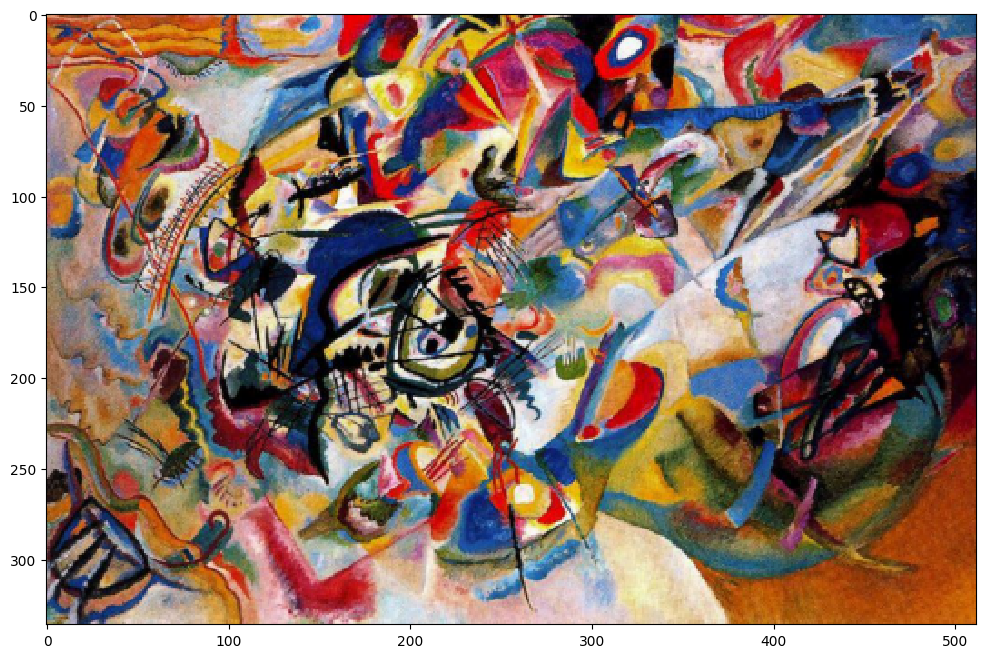

In [4]:
print(style_img.shape)
pt.imshow(style_img[0])

In [0]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

n_content_layer = len(content_layers)
n_style_layer = len(style_layers)

In [0]:
class BuildGraph:
    def __init__(self):
        content = tf.constant(content_img, dtype=tf.float32)
        style = tf.constant(style_img, dtype=tf.float32)
        self.combination = tf.Variable(content_img, dtype=tf.float32)#+np.random.normal(scale=0.1, size=content_img.shape), dtype=tf.float32)
        
        self.content_weight = tf.placeholder(tf.float32, [])
        self.style_weight = tf.placeholder(tf.float32, [])
        self.variation_weight = tf.placeholder(tf.float32, [])
        
        self.lr_rate = tf.placeholder(tf.float32, [])
        
        content_features = self.vgg_layers(content_layers, content)
        style_features = self.vgg_layers(style_layers, style)
        combination_features = self.vgg_layers(content_layers+style_layers, self.combination)
        
        self.content_loss = 0
        for i in range(n_content_layer):
            self.content_loss = self.content_loss+tf.reduce_mean((content_features[i]-combination_features[i])**2)
        self.content_loss = self.content_loss*self.content_weight/n_content_layer
        
        self.style_loss = 0
        for i in range(n_style_layer):
            style_matrix = self.gram_matrix(style_features[i])
            combination_matrix = self.gram_matrix(combination_features[i+n_content_layer])
            self.style_loss = self.style_loss+tf.reduce_mean((style_matrix-combination_matrix)**2)        
        self.style_loss = self.style_loss*self.style_weight/n_style_layer
        
        var_loss1 = (self.combination[:, :-1, :-1, :]-self.combination[:, 1:, :-1, :])**2
        var_loss2 = (self.combination[:, :-1, :-1, :]-self.combination[:, :-1, 1:, :])**2
        self.variation_loss = tf.reduce_mean(tf.pow(var_loss1+var_loss2, 1.25))*self.variation_weight
        
        self.loss = self.content_loss+self.style_loss+self.variation_loss

        self.train_step = tf.train.AdamOptimizer(self.lr_rate, beta1=0.99, epsilon=1e-1).minimize(self.loss, var_list=[self.combination])
        
    def vgg_layers(self, layer_names, img):
        # img is from 0 to 1, so multiply by 255
        model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=img*255)
        outputs = [model.get_layer(layer_name).output for layer_name in layer_names]
        return outputs
        
    def gram_matrix(self, x):
        num_locations = tf.cast(x.shape[1]*x.shape[2], tf.float32)
        gram = tf.linalg.einsum('bijc,bijd->bcd', x, x)/num_locations
        return gram

In [7]:
graph = BuildGraph()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i_epoch in range(20):
        _, content_loss, style_loss, variation_loss = \
        sess.run((graph.train_step, graph.content_loss, graph.style_loss, graph.variation_loss),
                  feed_dict={graph.content_weight: 1e4,
                             graph.style_weight: 1e-2,
                             graph.variation_weight: 0,
                             graph.lr_rate: 0.01})
        print('epoch %d, content_loss = %.6e, style_loss = %.6e, variation_loss = %.6e'%(i_epoch,
                                                                                         content_loss,
                                                                                         style_loss,
                                                                                         variation_loss))
        #print('epoch %d, loss = %.6e'%(i_epoch, content_loss+style_loss+variation_loss))
        
        #combination_img = combination_img[0, :, :, ::-1]+img_mean_val
        #combination_img = np.clip(combination_img, 0, 255).astype(np.uint8)
        #pt.imshow(combination_img)
        #pt.show()
    
    combination_img = sess.run((graph.combination))
    combination_img = np.clip(combination_img[0], 0, 1)
    
    pt.imshow(combination_img)

AttributeError: ignored

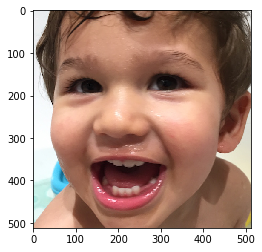

In [44]:
pt.imshow((content_img[0, :, :, ::-1]+img_mean_val).astype(np.uint8))